In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from datetime import datetime
#mpl.use('TkAgg')

C:\Users\ivano\AppData\Local\Temp\ipykernel_712\622345656.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
#list_name = "Carbon-loc-isoth-N2.xlsx"
list_name = "Silica-loc-isoth1.xlsx"
dataframe_sorb = pd.read_excel(list_name, header=None, sheet_name="Adsorption")
dataframe_desorb = pd.read_excel(list_name, header=None, sheet_name="Desorption")
P_START = 21  # индекс минимального давления
p_array = np.array(dataframe_sorb[0][P_START:])  # сетка давлений
a_array = np.array(dataframe_sorb.iloc[0][1:])  # сетка размеров пор

array_of_isotherms = np.empty((len(a_array), len(p_array)))  # массив изотерм с i-м размером пор
for i in range(len(a_array)):  # заполняем массив изотерм из таблицы pandas
    array_of_isotherms[i] = dataframe_sorb[i+1][P_START:]
    
array_of_isotherms_d = np.empty((len(a_array), len(p_array)))  # массив десорбционных изотерм с i-м размером пор
for i in range(len(a_array)):  # заполняем массив изотерм из таблицы pandas
    array_of_isotherms_d[i] = dataframe_desorb[i+1][P_START:]

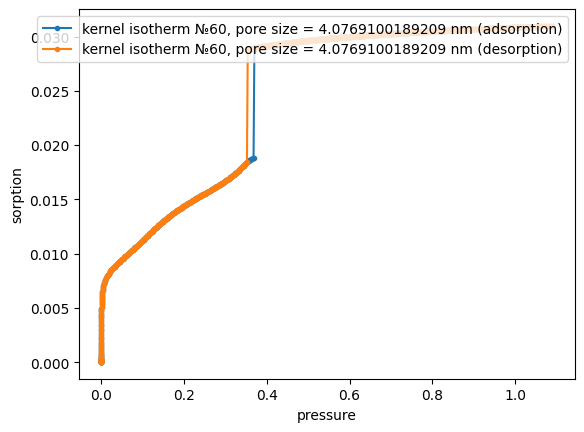

In [3]:
j = 60
fig, ax=plt.subplots()  # строим график j-й изотермы из исходного набора
ax.plot(p_array, array_of_isotherms[j], marker=".", label=f"kernel isotherm №{j}, pore size = {a_array[j]} nm (adsorption)")
ax.plot(p_array, array_of_isotherms_d[j], marker=".", label=f"kernel isotherm №{j}, pore size = {a_array[j]} nm (desorption)")
ax.set_ylabel("sorption")
ax.set_xlabel("pressure")
legend = ax.legend(loc='upper right')
plt.show()    

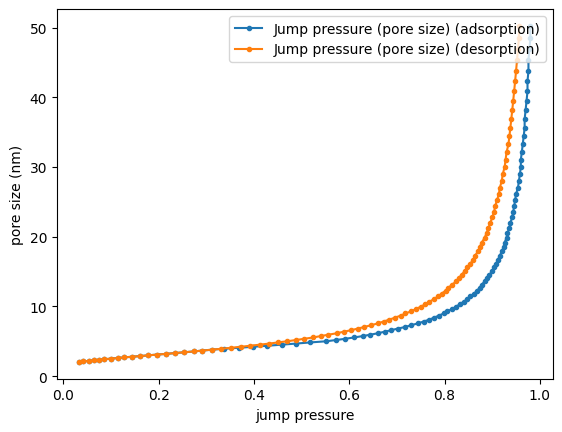

In [4]:
#  обработка изотерм со скачком
pore_size_jump_pressure = pd.DataFrame(columns=['pore_size', 'pressure_of_jump'])  # таблица размер пор - давление при котором происходит скачок в изотерме с данным размером пор
for i, sorption_a in enumerate(array_of_isotherms):
    sorption_delta_array = sorption_a[1:] - sorption_a[:-1]
    jump_i = np.argmax(sorption_delta_array)  # индекс скачка 
    jump_pressure = p_array[jump_i]  #  давление скачка
    pore_size_jump_pressure.loc[len(pore_size_jump_pressure.index)] = [a_array[i], jump_pressure]
    
pore_size_jump_pressure_d = pd.DataFrame(columns=['pore_size', 'pressure_of_jump'])  # таблица размер пор - давление при котором происходит скачок в изотерме с данным размером пор
for i, sorption_a in enumerate(array_of_isotherms_d):
    sorption_delta_array = sorption_a[1:] - sorption_a[:-1]
    jump_i = np.argmax(sorption_delta_array)  # индекс скачка 
    jump_pressure = p_array[jump_i]  #  давление скачка
    pore_size_jump_pressure_d.loc[len(pore_size_jump_pressure_d.index)] = [a_array[i], jump_pressure]


#j_first_step = 23 # для silica
j_first_step = 40 # для carbon
pore_size_jump_pressure_cut = pore_size_jump_pressure[j_first_step:]
pore_size_jump_pressure_d_cut = pore_size_jump_pressure_d[j_first_step:]

fig, ax=plt.subplots()
ax.plot(pore_size_jump_pressure_cut["pressure_of_jump"], pore_size_jump_pressure_cut["pore_size"], marker=".", label="Jump pressure (pore size) (adsorption)")
ax.plot(pore_size_jump_pressure_d_cut["pressure_of_jump"], pore_size_jump_pressure_d_cut["pore_size"], marker=".", label="Jump pressure (pore size) (desorption)")
ax.set_ylabel("pore size (nm)")
ax.set_xlabel("jump pressure")
legend = ax.legend(loc='upper right')
plt.show()

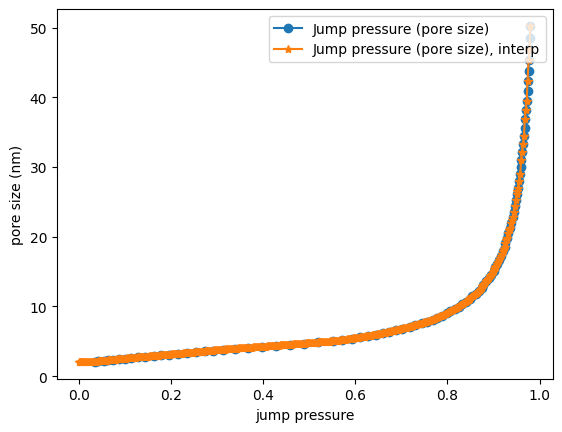

In [5]:
# получаем размеры пор в которых происходит скачок интерполяцией для кажой точки из сетки давлений
new_a_array_raw = np.interp(p_array,  pore_size_jump_pressure_cut["pressure_of_jump"].to_numpy(), pore_size_jump_pressure_cut["pore_size"].to_numpy())
#new_a_array = new_a_array_raw[j_no_step:jump_i+1]  # обрезаем массив пор так как для последних и первых давлений не было изотерм со скачками

j_last_step = np.where(p_array == pore_size_jump_pressure_cut.iloc[-1]["pressure_of_jump"])[0][0] + 1 #  индекс давления последнего скачка


fig, ax=plt.subplots()
ax.plot(pore_size_jump_pressure_cut["pressure_of_jump"], pore_size_jump_pressure_cut["pore_size"], marker="o", label="Jump pressure (pore size)")
ax.plot(p_array[j_first_step:j_last_step], new_a_array_raw[j_first_step:j_last_step], marker="*", label="Jump pressure (pore size), interp")
ax.set_ylabel("pore size (nm)")
ax.set_xlabel("jump pressure")
legend = ax.legend(loc='upper right')
plt.show()
new_a_array = new_a_array_raw[j_first_step:j_last_step]

In [6]:
def get_k_b(x1, y1, x2, y2):
    k = (y1 - y2) / (x1 - x2)
    b = y1 - k*x1
    return k, b

A_START = j_first_step
step_array_train = pore_size_jump_pressure["pressure_of_jump"].to_numpy()
def generate_kernel_isotherm(step_i):
    curent_a_size = new_a_array[step_i]
    new_isotherm = np.zeros(shape=p_array.shape)
    j1, j2  = sorted((np.abs(a_array - curent_a_size)).argsort()[:2])  # находим индексы ближайших к текущему размеров пор
    
    if curent_a_size == a_array[j1]:
        return array_of_isotherms[j1]
    if curent_a_size == a_array[j2]:
        return array_of_isotherms[j2]
    
    i = 0
    while p_array[i] <= pore_size_jump_pressure["pressure_of_jump"][j1]:
        new_isotherm[i] = np.interp(curent_a_size, xp=(a_array[j1], a_array[j2]), fp=(array_of_isotherms[j1][i], array_of_isotherms[j2][i]))
        i += 1
    tmp = i
    
    i = len(p_array) - 1
    while p_array[i] > pore_size_jump_pressure["pressure_of_jump"][j2]:
        new_isotherm[i] = np.interp(curent_a_size, xp=(a_array[j1], a_array[j2]), fp=(array_of_isotherms[j1][i], array_of_isotherms[j2][i]))
        i -= 1
    
    while p_array[i] > p_array[step_i+A_START]:
        k, b = get_k_b(p_array[i+2], new_isotherm[i+2],  p_array[i+1],  new_isotherm[i+1])
        new_isotherm[i] =  p_array[i] * k + b
        i -= 1
    
    i = tmp
    while p_array[i] <= p_array[step_i+A_START]:
        k, b = get_k_b(p_array[i-2], new_isotherm[i-2],  p_array[i-1],  new_isotherm[i-1])
        new_isotherm[i] =  p_array[i] * k + b
        i += 1
    
    return new_isotherm
    
    
result = []
for step_i in range(len(new_a_array)):
    result.append(generate_kernel_isotherm(step_i))

new isotherm pore size = 4.124473206636081 nm
base isotherm 60 pore size = 4.0769100189209 nm
base isotherm 61 pore size = 4.21959972381592 nm


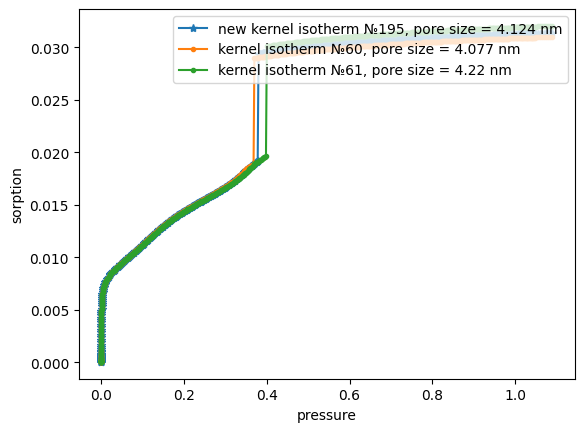

In [7]:
#  строим графики и изучаем новую j-ю изотерму и корневые, по котором ее сгенерировали
fig, ax=plt.subplots()
j = 195
j1, j2 = sorted((np.abs(a_array - new_a_array[j])).argsort()[:2])  # находим индексы ближайших к текущему размеров пор

print(f"new isotherm pore size = {new_a_array[j]} nm")
print(f"base isotherm {j1} pore size = {a_array[j1]} nm")
print(f"base isotherm {j2} pore size = {a_array[j2]} nm")

ax.plot(p_array, result[j], marker = "*", label=f"new kernel isotherm №{j}, pore size = {round(new_a_array[j], 3)} nm")
ax.plot(p_array,  array_of_isotherms[j1], marker = ".", label=f"kernel isotherm №{j1}, pore size = {round(a_array[j1], 3)} nm")
ax.plot(p_array, array_of_isotherms[j2], marker = ".", label=f"kernel isotherm №{j2}, pore size = {round(a_array[j2], 3)} nm")

legend = ax.legend(loc='upper right')
ax.set_ylabel("sorption")
ax.set_xlabel("pressure")
plt.show()

In [8]:
# анимация всех новых изотерм
def create_animation(file):
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 5, True)
    line1, = ax.plot(p_array, result[0], marker = ".", label="")
    j1, j2 = sorted((np.abs(a_array - new_a_array[0])).argsort()[:2])
    line2, = ax.plot(p_array, array_of_isotherms[j1], marker = ".", label="")
    line3, = ax.plot(p_array, array_of_isotherms[j2], marker = ".", label="")

    texts = [ax.text(0.70, 0.1-i*0.05,  '', transform=ax.transAxes) for i in range(3)]

    ax.set_xlim(0, 1)
    ax.set_ylim(0, array_of_isotherms[j2][-1])
    ax.set_ylabel("sorption")
    ax.set_xlabel("pressure")
    def update(frame):
        line1.set_ydata(result[frame])
        j1, j2 = sorted((np.abs(a_array - new_a_array[frame])).argsort()[:2])
        line2.set_ydata(array_of_isotherms[j1])
        line3.set_ydata(array_of_isotherms[j2])
        ax.set_ylim(0, array_of_isotherms[j2][-1]*1.1)
        texts[0].set_text(f"new kernel isotherm №{frame}, pore size = {round(new_a_array[frame], 2)} nm")
        texts[1].set_text(f"kernel isotherm №{j1}, pore size = {round(a_array[j1], 2)} nm")
        texts[2].set_text(f"kernel isotherm №{j2}, pore size = {round(a_array[j2], 2)} nm")
        return (line1, line2, line3)

    ani = animation.FuncAnimation(fig=fig, func=update, frames=len(result), interval=100)
    writervideo = animation.FFMpegWriter(fps=len(result)/100)
    ani.save(file, writer=writervideo, dpi = 200)
    plt.show()
    
#create_animation('test.mp4')

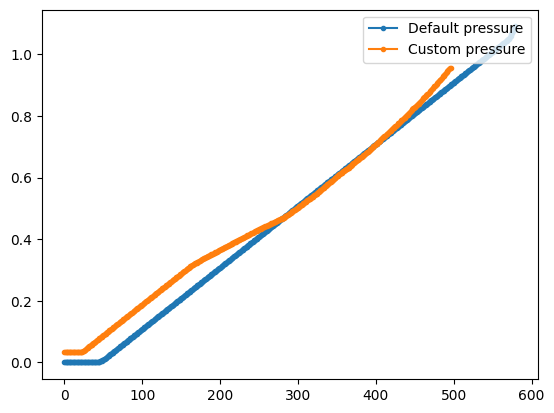

In [9]:
# десорбция
# Находим сетку давлений для десорбции
part_of_new_p_array = np.interp(new_a_array, pore_size_jump_pressure_d["pore_size"], pore_size_jump_pressure_d["pressure_of_jump"].to_numpy())
fig, ax=plt.subplots()
ax.plot(p_array, label="Default pressure", marker = ".")
ax.plot(part_of_new_p_array, label="Custom pressure", marker = ".")
legend = ax.legend(loc='upper right')
plt.show()

In [10]:
# строим изотермы десорбции
def generate_kernel_isotherm_d(step_i):
    current_a_size = new_a_array[step_i]
    new_isotherm = np.zeros(shape=part_of_new_p_array.shape)
    j1, j2  = sorted((np.abs(a_array - current_a_size)).argsort()[:2])  # находим индексы ближайших к текущему размеров пор
    
    if current_a_size == a_array[j1]:
        return np.interp(part_of_new_p_array, p_array, array_of_isotherms_d[j1])
    if current_a_size == a_array[j2]:
        return np.interp(part_of_new_p_array, p_array, array_of_isotherms_d[j2])
    
    i = 0
    while part_of_new_p_array[i] <= pore_size_jump_pressure_d["pressure_of_jump"][j1]:
        i1, i2  = sorted((np.abs(p_array - part_of_new_p_array[i])).argsort()[:2])
        s1 = np.interp(part_of_new_p_array[i], (p_array[i1], p_array[i2]),(array_of_isotherms_d[j1][i1], array_of_isotherms_d[j1][i2])) # интерполяция корневых изотрем под новую сетку давлений 
        s2 = np.interp(part_of_new_p_array[i], (p_array[i1], p_array[i2]),(array_of_isotherms_d[j2][i1], array_of_isotherms_d[j2][i2]))
        new_isotherm[i] = np.interp(current_a_size, xp=(a_array[j1], a_array[j2]), fp=(s1, s2))
        i += 1
    tmp = i
    
    i = len(part_of_new_p_array) - 1
    while p_array[min((np.abs(p_array - part_of_new_p_array[i])).argsort()[:2])] > pore_size_jump_pressure_d["pressure_of_jump"][j2]:
        i1, i2  = sorted((np.abs(p_array - part_of_new_p_array[i])).argsort()[:2])
        s1 = np.interp(part_of_new_p_array[i], (p_array[i1], p_array[i2]),(array_of_isotherms_d[j1][i1], array_of_isotherms_d[j1][i2]))
        s2 = np.interp(part_of_new_p_array[i], (p_array[i1], p_array[i2]),(array_of_isotherms_d[j2][i1], array_of_isotherms_d[j2][i2]))
        new_isotherm[i] = np.interp(current_a_size, xp=(a_array[j1], a_array[j2]), fp=(s1, s2))
        i -= 1
        
    step_pressure = part_of_new_p_array[step_i]
    while part_of_new_p_array[i] >= step_pressure and i >=0:
        try:
            k, b = get_k_b(part_of_new_p_array[i+2], new_isotherm[i+2],  part_of_new_p_array[i+1],  new_isotherm[i+1])
            new_isotherm[i] =  part_of_new_p_array[i] * k + b
        except IndexError:
            i1, i2  = sorted((np.abs(p_array - part_of_new_p_array[i])).argsort()[:2])
            new_isotherm[i] =  array_of_isotherms_d[j2][i2]
        i -= 1

    i = tmp
    while part_of_new_p_array[i] <= step_pressure:
        k, b = get_k_b(part_of_new_p_array[i-2], new_isotherm[i-2],  part_of_new_p_array[i-1],  new_isotherm[i-1])
        new_isotherm[i] =  part_of_new_p_array[i] * k + b
        i += 1

    return new_isotherm
    

result_d = []
for step_i in range(len(new_a_array)):
     result_d.append(generate_kernel_isotherm_d(step_i))

C:\Users\ivano\AppData\Local\Temp\ipykernel_9332\504336819.py:2: RuntimeWarning: invalid value encountered in scalar divide
  k = (y1 - y2) / (x1 - x2)


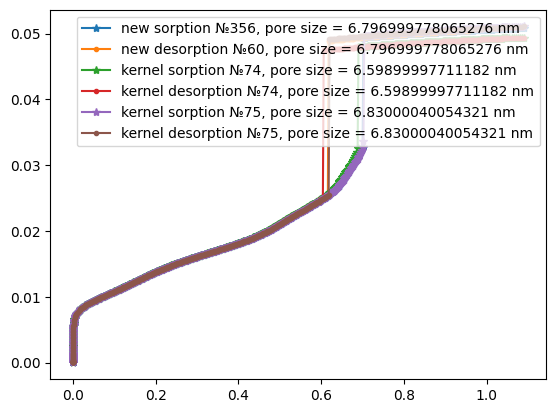

In [11]:
fig, ax=plt.subplots()
j = 356
ax.plot(p_array, result[j], marker="*", label=f"new sorption №{j}, pore size = {new_a_array[j]} nm")
ax.plot(part_of_new_p_array, result_d[j], marker=".", label=f"new desorption №{j1}, pore size = {new_a_array[j]} nm")

j1, j2  = sorted((np.abs(a_array - new_a_array[j])).argsort()[:2])
ax.plot(p_array, array_of_isotherms[j1], marker="*", label=f"kernel sorption №{j1}, pore size = {a_array[j1]} nm")
ax.plot(p_array, array_of_isotherms_d[j1], marker=".", label=f"kernel desorption №{j1}, pore size = {a_array[j1]} nm")
ax.plot(p_array, array_of_isotherms[j2], marker="*", label=f"kernel sorption №{j2}, pore size = {a_array[j2]} nm")
ax.plot(p_array, array_of_isotherms_d[j2], marker=".", label=f"kernel desorption №{j2}, pore size = {a_array[j2]} nm")

legend = ax.legend(loc='upper right')
plt.show() 

In [12]:
# достраиваем изотермы десорбции в оставшихся давлениях
p_i1 = (np.abs(p_array - part_of_new_p_array[0])).argsort()[:1][0]  # индексы давлений с начальной сетки
p_i2 = (np.abs(p_array - part_of_new_p_array[-1])).argsort()[:1][0]
def generate_kernel_isotherm_d_in_rest_pressure(j):
    current_a_size = new_a_array[j]
    j1, j2  = sorted((np.abs(a_array - current_a_size)).argsort()[:2])  # находим индексы ближайших к текущему размеров пор
    i = 0
    tmp = []
    while p_array[i] < p_array[p_i1]:
        tmp.append(np.interp(current_a_size, xp=(a_array[j1], a_array[j2]), fp=(array_of_isotherms_d[j1][i], array_of_isotherms_d[j2][i])))
        i += 1
    res = np.concatenate((np.array(tmp), result_d[j]), axis=0)
    
    i = -1
    tmp = []
    while p_array[i] >= p_array[p_i2]:
        tmp.append(np.interp(current_a_size, xp=(a_array[j1], a_array[j2]), fp=(array_of_isotherms_d[j1][i], array_of_isotherms_d[j2][i])))
        i -= 1    
    return np.concatenate((res, np.array(tmp[::-1])), axis=0)

new_result_d = []
for j in range(len(result_d)):
     new_result_d.append(generate_kernel_isotherm_d_in_rest_pressure(j))

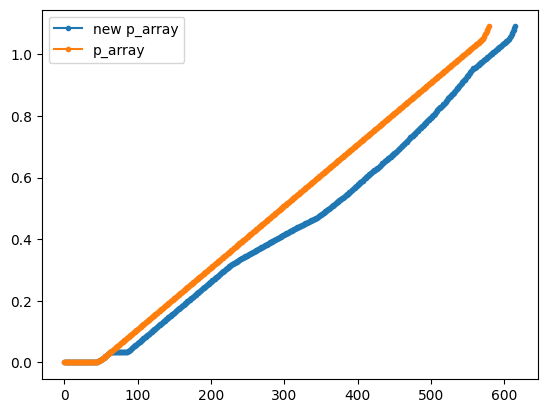

In [13]:
new_p_array = np.concatenate((p_array[:p_i1], part_of_new_p_array, p_array[p_i2:]), axis=0)
plt.plot(new_p_array, label="new p_array", marker=".")
plt.plot(p_array, label="p_array", marker=".")
plt.legend()
plt.show()

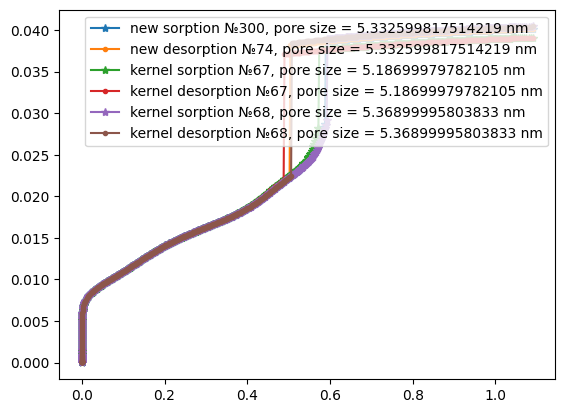

In [14]:
fig, ax=plt.subplots()
j = 300
ax.plot(p_array, result[j], marker="*", label=f"new sorption №{j}, pore size = {new_a_array[j]} nm")
ax.plot(new_p_array, new_result_d[j], marker=".", label=f"new desorption №{j1}, pore size = {new_a_array[j]} nm")

j1, j2  = sorted((np.abs(a_array - new_a_array[j])).argsort()[:2])
ax.plot(p_array, array_of_isotherms[j1], marker="*", label=f"kernel sorption №{j1}, pore size = {a_array[j1]} nm")
ax.plot(p_array, array_of_isotherms_d[j1], marker=".", label=f"kernel desorption №{j1}, pore size = {a_array[j1]} nm")
ax.plot(p_array, array_of_isotherms[j2], marker="*", label=f"kernel sorption №{j2}, pore size = {a_array[j2]} nm")
ax.plot(p_array, array_of_isotherms_d[j2], marker=".", label=f"kernel desorption №{j2}, pore size = {a_array[j2]} nm")

legend = ax.legend(loc='upper right')
plt.show() 

In [15]:
N = (np.abs(a_array - new_a_array[0])).argsort()[0]  # находим индекс последней изотермы с корневого набора, которую мы оставляем

new_kernel_set = np.concatenate((array_of_isotherms[:N], np.array(result)), axis=0)
new_a_size_set = np.concatenate((a_array[:N], new_a_array), axis=0)


array_of_isotherms_d_interp = np.empty(shape=(len(new_kernel_set), len(new_p_array)))
for i, isotherm_d in enumerate(array_of_isotherms_d[:N]):  # приводим к одной сетке давлений первые изотермы десорбции из начального набора
    array_of_isotherms_d_interp[i] = np.interp(new_p_array, p_array, isotherm_d)

new_kernel_d_lst = []  # Соединяем первые исходные и новые изотермы десорбции
for i in range(N):
    new_kernel_d_lst.append(array_of_isotherms_d_interp[i])
for i in range(len(new_result_d)):
    new_kernel_d_lst.append(np.array(new_result_d[i]))
new_kernel_d_set = np.array(new_kernel_d_lst, dtype=object)

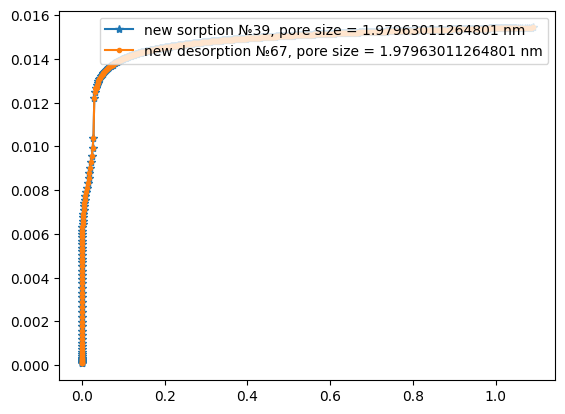

In [16]:
fig, ax=plt.subplots()
j = 39
ax.plot(p_array, new_kernel_set[j], marker="*", label=f"new sorption №{j}, pore size = {new_a_size_set[j]} nm")
ax.plot(new_p_array, new_kernel_d_set[j], marker=".", label=f"new desorption №{j1}, pore size = {new_a_size_set[j]} nm")

# j1, j2  = sorted((np.abs(a_array - new_a_size_set[j])).argsort()[:2])
# ax.plot(p_array, array_of_isotherms[j1], marker="*", label=f"kernel sorption №{j1}, pore size = {a_array[j1]} nm")
# ax.plot(p_array, array_of_isotherms_d[j1], marker=".", label=f"kernel desorption №{j1}, pore size = {a_array[j1]} nm")
# ax.plot(p_array, array_of_isotherms[j2], marker="*", label=f"kernel sorption №{j2}, pore size = {a_array[j2]} nm")
# ax.plot(p_array, array_of_isotherms_d[j2], marker=".", label=f"kernel desorption №{j2}, pore size = {a_array[j2]} nm")

legend = ax.legend(loc='upper right')
plt.show() 

In [17]:
# сохраняем изотермы и размеры пор в формате np
#now = datetime.now().strftime('%Y-%m-%d_T_%H-%M-%S')
with open(f'data/kernel_generated2/Kernel_s_{list_name}.npy', 'wb') as f:
    np.save(f, new_kernel_set)
    
with open(f'data/kernel_generated2/Kernel_d_{list_name}.npy', 'wb') as f:
    np.save(f, new_kernel_d_set)

with open(f'data/kernel_generated2/Size_{list_name}.npy', 'wb') as f:
    np.save(f, new_a_size_set)
    
with open(f'data/kernel_generated2/Pressure_d_{list_name}.npy', 'wb') as f:
    np.save(f, new_p_array)
    
with open(f'data/kernel_generated2/Pressure_s_{list_name}.npy', 'wb') as f:
    np.save(f, p_array)